In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
START_DATE = '2019-01-01'
END_DATE = '2021-01-06'
ATT = 'T'
VERIZON = 'VZ'
SP500 = 'SP&500'

Before running this code, 'mykey' in the url need to be replaced with api key. The api key is freely obtainable from https://www.alphavantage.co/ .

In [3]:
def load_csv_parse(symbol):
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+symbol+"&outputsize=full&apikey=mykey&datatype=csv"
    df = pd.read_csv(url, parse_dates = ['timestamp'], index_col = 'timestamp')
    
    return df

In [4]:
def extract_slice(df):
    return df.sort_index().loc[START_DATE:END_DATE]

In [5]:
def normalize(df):
    return df.div(df.iloc[0]).mul(100)

In [6]:
def upsample(series):
    return series.asfreq("W",method="bfill")

In [7]:
def components(series):
    add = seasonal_decompose(series, model='additive')
    return add

#### Loading historical AT&T and Verizon stock prices from Alpha Vantage API

In [8]:
df_T = load_csv_parse(ATT)

In [9]:
df_T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5786 entries, 2022-10-27 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5786 non-null   float64
 1   high    5786 non-null   float64
 2   low     5786 non-null   float64
 3   close   5786 non-null   float64
 4   volume  5786 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 271.2 KB


In [10]:
df_VZ = load_csv_parse(VERIZON)

In [11]:
df_VZ.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5786 entries, 2022-10-27 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5786 non-null   float64
 1   high    5786 non-null   float64
 2   low     5786 non-null   float64
 3   close   5786 non-null   float64
 4   volume  5786 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 271.2 KB


#### Loading S&P 500 benchmark data

In [12]:
df_sp500 = load_csv_parse(SP500)

In [13]:
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4635 entries, 2022-10-27 to 2004-06-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4635 non-null   float64
 1   high    4635 non-null   float64
 2   low     4635 non-null   float64
 3   close   4635 non-null   float64
 4   volume  4635 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 217.3 KB


### Data Analysis steps:
- Analyze historical daily closing stock prices for the period 2019-01-02 to 2021-01-06
- Visualize time series data of the two stocks
- Apply normalization to compare how the stocks perform relative to each other, and against a benchmark

In [14]:
dataset = pd.concat([df_T.close,df_VZ.close],axis = 1,keys = [ATT, VERIZON])
dataset = extract_slice(dataset)
dataset.head()

,T,VZ
timestamp,,
2019-01-02,29.54,56.02
2019-01-03,29.58,56.22
2019-01-04,30.34,56.36
2019-01-07,30.89,56.72
2019-01-08,31.28,58.38


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2019-01-02 to 2021-01-06
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       508 non-null    float64
 1   VZ      508 non-null    float64
dtypes: float64(2)
memory usage: 11.9 KB


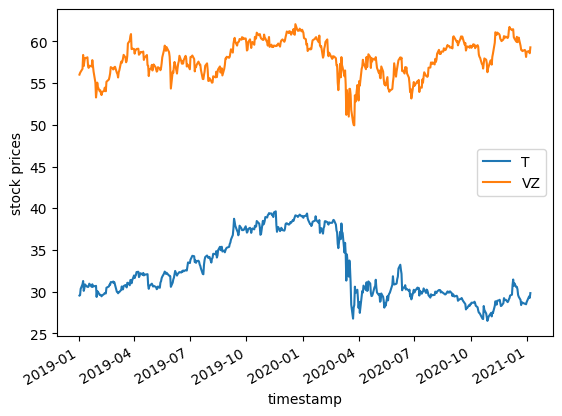

In [16]:
dataset.plot()
plt.ylabel("stock prices");

In [17]:
# Normalize data for comparison of stock growth rates
normalized =normalize(dataset)

In [18]:
normalized.head(3)

,T,VZ
timestamp,,
2019-01-02,100.000000,100.000000
2019-01-03,100.135410,100.357015
2019-01-04,102.708192,100.606926


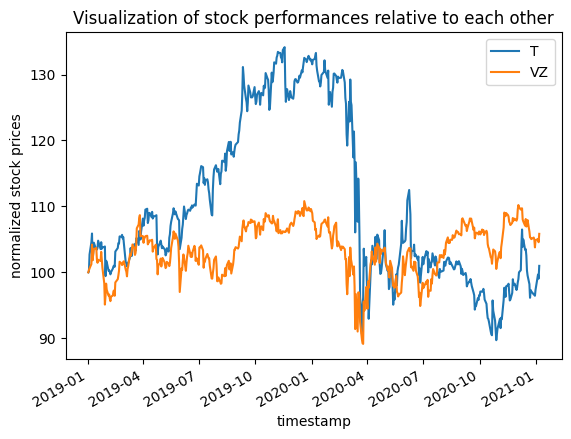

In [19]:
normalized.plot()
plt.ylabel("normalized stock prices");
plt.title("Visualization of stock performances relative to each other");

In [20]:
benchmark = extract_slice(df_sp500)
benchmark = benchmark['close'].rename(SP500)

In [21]:
dataset = pd.concat([dataset,benchmark],axis = 1)

In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2019-01-02 to 2021-01-06
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       508 non-null    float64
 1   VZ      508 non-null    float64
 2   SP&500  508 non-null    float64
dtypes: float64(3)
memory usage: 15.9 KB


In [23]:
# Normalize data for comparison of stock growth rates
normalized_bench = normalize(dataset)

In [24]:
normalized_bench.head(3)

,T,VZ,SP&500
timestamp,,,
2019-01-02,100.000000,100.000000,100.000000
2019-01-03,100.135410,100.357015,97.186872
2019-01-04,102.708192,100.606926,100.133958


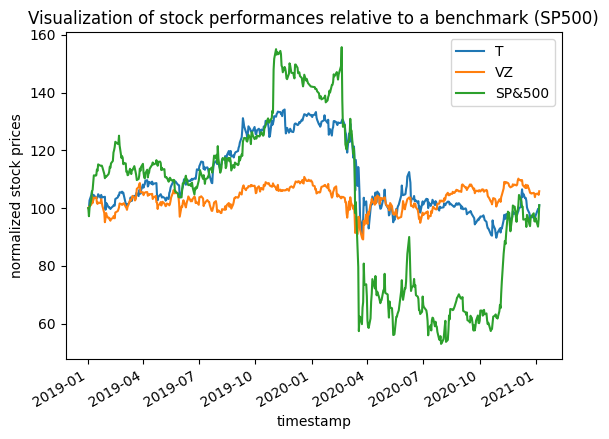

In [25]:
normalized_bench.plot()
plt.ylabel("normalized stock prices");
plt.title("Visualization of stock performances relative to a benchmark (SP500)");

### Extraction of Trend, Seasonality, Noise from Time Series

In [26]:
series_T = extract_slice(df_T)["close"].rename(ATT)
series_T.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 508 entries, 2019-01-02 to 2021-01-06
Series name: T
Non-Null Count  Dtype  
--------------  -----  
508 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


In [27]:
series_T = upsample(series_T)
series_T.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 105 entries, 2019-01-06 to 2021-01-03
Freq: W-SUN
Series name: T
Non-Null Count  Dtype  
--------------  -----  
105 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


In [28]:
series_T.head()

timestamp
2019-01-06    30.89
2019-01-13    30.62
2019-01-20    30.58
2019-01-27    30.67
2019-02-03    29.61
Freq: W-SUN, Name: T, dtype: float64

In [29]:
comp_T_add = components(series_T)

#### Components of AT&T with Additive Noise

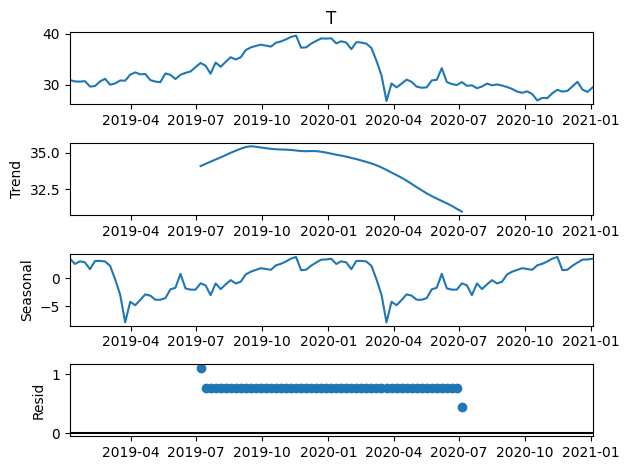

In [30]:
comp_T_add.plot();

In [31]:
series_VZ = extract_slice(df_VZ)["close"].rename(VERIZON)
series_VZ.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 508 entries, 2019-01-02 to 2021-01-06
Series name: VZ
Non-Null Count  Dtype  
--------------  -----  
508 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


In [32]:
series_VZ = upsample(series_VZ)
series_VZ.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 105 entries, 2019-01-06 to 2021-01-03
Freq: W-SUN
Series name: VZ
Non-Null Count  Dtype  
--------------  -----  
105 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


In [33]:
series_VZ.head()

timestamp
2019-01-06    56.72
2019-01-13    58.03
2019-01-20    56.99
2019-01-27    55.07
2019-02-03    54.04
Freq: W-SUN, Name: VZ, dtype: float64

In [34]:
comp_VZ_add = components(series_VZ)

#### Components of Verizon with Additive Noise

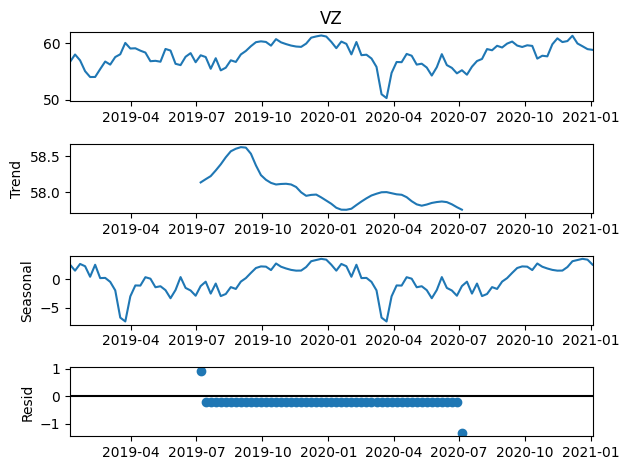

In [35]:
comp_VZ_add.plot();

The seasonal_decompose is used to visualize trend and seasonality in time series. In both cases above there is no clear trend or a periodic seasonal curve to be seen. 
To furthur analyse trend and seasonality for the two stocks, we use autocorrelation functions (ACF and PACF).